# BSOC as a Convoultional Layer

This work is based on papers by Dr. Gabriel Ferrer from Hendrix College. I will explore the practicality of using Bounded Self-Organizing Clusters (BSOC) as a way to create the first convoultional in a convoultional network. I will be using Pytorch as a baseline in this notebook.

## Data:
The data comes from pictures taken on a Galaxy S8 at 1280x720px.
### 7/9/2018
Room: 10 Pictures <br/>
Kitchen: 10 Pictures

## 1: Running a basic test with CIFAR10:

In [1]:
## Loading the Data
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))



# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Files already downloaded and verified
Files already downloaded and verified
  car  ship  ship truck


In [31]:
import torch.nn as nn
import torch.nn.functional as F


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.fc1 = nn.Linear(10 * 28 * 28, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 10 * 28 * 28)
        x = self.fc1(x)
        return x
#     def __init__(self):
#         super(ConvNet, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         print(x.size())
#         x = self.pool(F.relu(self.conv1(x)))
#         print(x.size())
#         x = self.pool(F.relu(self.conv2(x)))
#         print(x.size())
#         x = x.view(-1, 16 * 5 * 5)
#         print(x.size())
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x



# class BSOCNet(nn.Module):
#     def __init__(self):
#         super(BSOCNet, self).__init__()
        
net = ConvNet()

It looks like from [here](https://discuss.pytorch.org/t/defining-a-conv2d-layer-with-fixed-kernel/8684) that we can use F.conv2d to manually define layers [documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.functional.conv2d) and [this](https://discuss.pytorch.org/t/pytorch-replace-torch-nn-conv2d-with-torch-nn-functional-conv2d/16596) link might help if we get errors

In [19]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [32]:

for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.310
[1,  4000] loss: 2.312
[1,  6000] loss: 2.312
[1,  8000] loss: 2.313
[1, 10000] loss: 2.312
[1, 12000] loss: 2.312
[2,  2000] loss: 2.312
[2,  4000] loss: 2.312
[2,  6000] loss: 2.310
[2,  8000] loss: 2.312
[2, 10000] loss: 2.311
[2, 12000] loss: 2.314
Finished Training


Evidently, using only a Convoluted layer and a MLP/Dense layer is not a good classifier. The commented out code above is the tuorial which gives much lower loss (around 1.12)

(10, 3, 5, 5)
(3,)
[[-0.09637843  0.08512098  0.11013851 -0.01549788  0.02775969]
 [ 0.06870964  0.05168772 -0.03357208 -0.06287108  0.02407114]
 [-0.0111529  -0.08104364  0.03487998 -0.10813116  0.00409912]
 [ 0.01432148  0.07148701  0.06743662 -0.0345263   0.05942763]
 [ 0.08592044  0.0579102  -0.0812898   0.05857071  0.0347359 ]]
0
[[ 0.10365884 -0.00947934  0.05508061  0.09593777  0.11002512]
 [ 0.02702767  0.11001402  0.07536751  0.06760682 -0.02529428]
 [-0.01035385 -0.02507612  0.04104014 -0.05594692 -0.03454244]
 [ 0.10841495 -0.07611939  0.07138833  0.02999318  0.04930627]
 [ 0.0108217   0.02096641  0.10466358  0.0571364  -0.09553624]]
10
[[ 0.10512796 -0.03005054 -0.00940652  0.08912785 -0.03248838]
 [ 0.0964251   0.11412682 -0.02998253  0.02109608 -0.06853302]
 [-0.06128663  0.01218118  0.10603376  0.01264136  0.06043579]
 [-0.07368945 -0.0846523  -0.02348094  0.02945076 -0.02664285]
 [-0.00015405 -0.02702193 -0.08856401  0.10429175  0.10138449]]
20


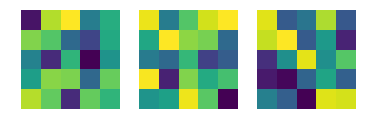

In [34]:
def view_kernels(tensor):
    width, height, kern_width, kern_height = tensor.shape
    _, axarr = plt.subplots(1 , height)
    print(axarr.shape)
    h = 0
    w = 0
    while ((h * height + w * width) < (height * width)):
        axarr[w].axis('off')
        axarr[w].imshow(tensor[w][h])
        print(tensor[w][h])
        print((h * height + w * width))
        w += 1
        if w >= width:
            h += 1
            w = 0
    
    
count = 0
for m in net.modules():
    if isinstance(m, nn.Conv2d):
        if count == 0:
            print((m.weight.data.numpy().shape))
            view_kernels(m.weight.data.numpy())
        count += 1